In [65]:
!pip install transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets
!pip install umap-learn
!pip install ipywidgets

In [66]:
from transformers import pipeline
import pandas as pd

## Text Classification

In [67]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 68676 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [68]:
# hide_output

from datasets import load_dataset

emotions = load_dataset("emotion")

In [69]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [70]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [71]:
len(train_ds)

16000

In [72]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [73]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [74]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


### Sidebar: What if my dataset is not on the hub?

In [75]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2023-10-08 15:49:42--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.23, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt.1’

train.txt.1         100%[===================>]   1.58M  6.04MB/s    in 0.3s    

2023-10-08 15:49:42 (6.04 MB/s) - ‘train.txt.1’ saved [1658616/1658616]



In [76]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


In [77]:
emotion_local = load_dataset("csv", data_files="train.txt", sep=';', names=["text", "label"])
emotion_local

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

In [78]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"

emotion_local = load_dataset("csv", data_files=dataset_url, sep=';', names=["text", "label"])
emotion_local

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

### From dataset to dataframes

In [79]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [80]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the dataset distribution

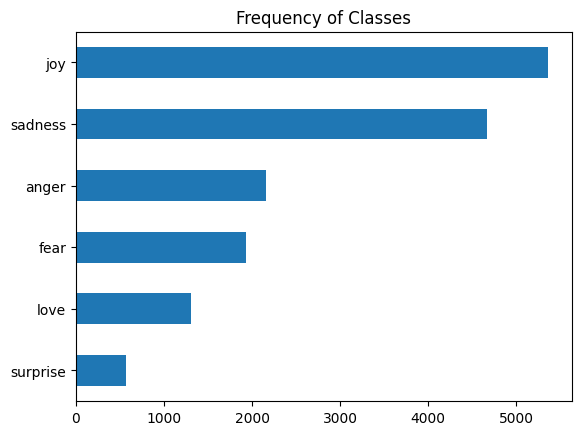

In [81]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### How long are our tweets

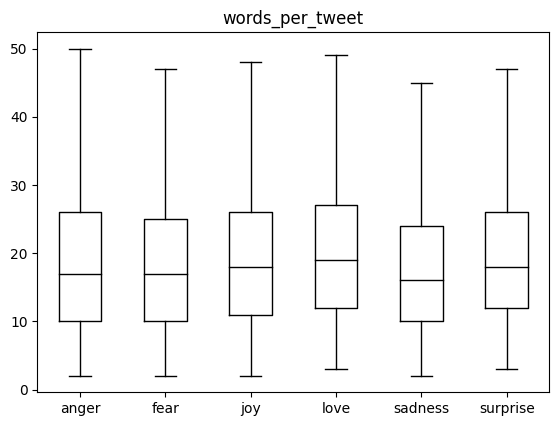

In [82]:
df["words_per_tweet"] = df["text"].str.split().apply(len)
df.boxplot("words_per_tweet", by="label_name", grid=False, showfliers=False,
           color="black")

plt.suptitle("")
plt.xlabel("")
plt.show()

In [83]:
emotions.reset_format()

### Character tokenization

In [84]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [85]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [86]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [87]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"],
     "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [88]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [89]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [90]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Word Tokenization

In [91]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### Subword Tokenization

In [92]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [93]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [94]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [95]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [96]:
tokenizer.vocab_size

30522

In [97]:
tokenizer.model_max_length

512

In [98]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing the whole dataset

In [99]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [100]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [101]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x: x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [102]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)


In [103]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier

### Transformers as feature extractors

In [104]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### Interoperability between frameworks

In [105]:
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [106]:
tf_xmlr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

### Extract the last hidden states

In [107]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
inputs

Input tensor shape: torch.Size([1, 6])


{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [108]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [109]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [110]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [111]:
def extract_hidden_states(batch):
    # Place model inputs on the gpu
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}

    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


In [112]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [113]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [114]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating feature matrix

In [115]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualizing the training set

In [116]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0, 1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,3.957609,6.322795,0
1,-3.336621,5.813243,0
2,4.731778,2.974174,3
3,-2.592863,3.628998,2
4,-3.667496,3.941504,3


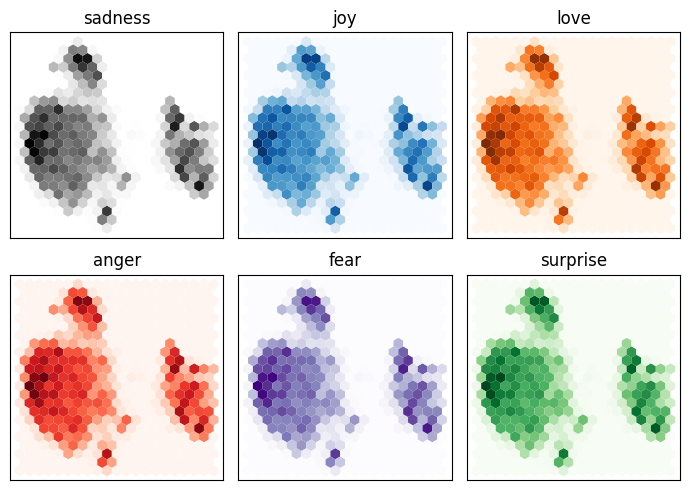

In [117]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names


for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb["X"], df_emb["Y"], cmap=cmap, gridsize=20,
                   linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Training a simple classifier

In [118]:
# We increase "max_iter" to guarantee convergence
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [119]:
lr_clf.score(X_valid, y_valid)

0.6335

In [120]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

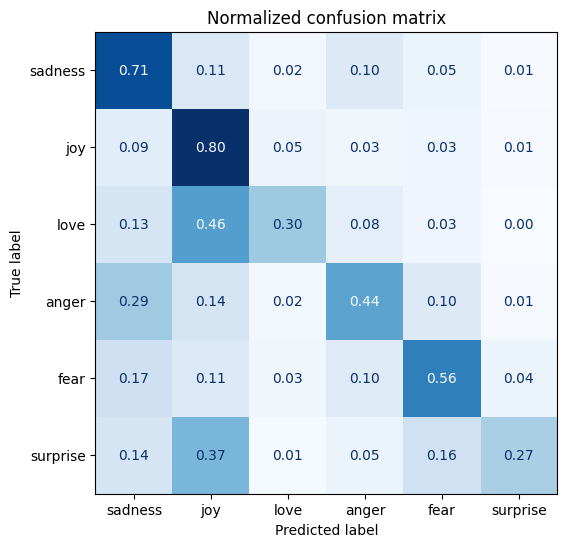

In [121]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine Tuning Transformers

### Loading a pretrained model

In [122]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels).to(device))

### Defining the performace metrics

In [123]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### Training the model

In [128]:
from huggingface_hub import notebook_login

notebook_login()

In [129]:
# !huggingface-cli login

In [130]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [131]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.831500,0.317720
2,0.248800,0.216519


TrainOutput(global_step=500, training_loss=0.5401603088378907, metrics={'train_runtime': 247.6355, 'train_samples_per_second': 129.222, 'train_steps_per_second': 2.019, 'total_flos': 720342861696000.0, 'train_loss': 0.5401603088378907, 'epoch': 2.0})

In [132]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [133]:
preds_output.metrics

{'test_loss': 0.21651901304721832,
 'test_runtime': 4.1782,
 'test_samples_per_second': 478.678,
 'test_steps_per_second': 7.659}

In [134]:
y_preds = np.argmax(preds_output.predictions, axis=1)

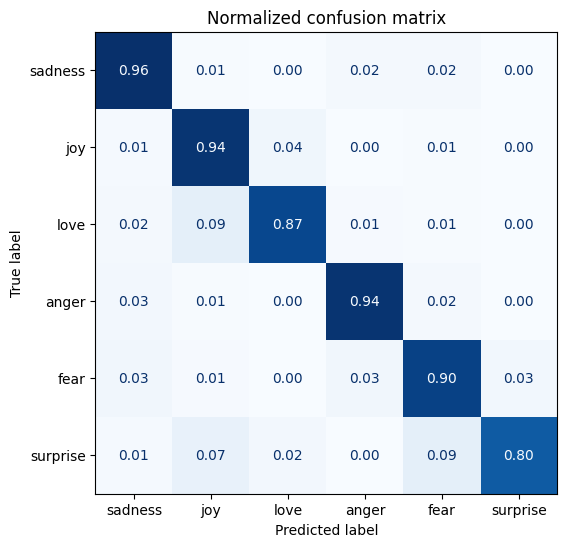

In [135]:
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning with keras

In [136]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

In [137]:
# The column names to convert to tensorflow tensors

tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"],
    shuffle=True, batch_size=batch_size)

tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"],
    shuffle=True, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [138]:
import tensorflow as tf

tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

### Error analysis

In [139]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [140]:
# Convert our dataset back to Pytorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [141]:
emotions_encoded.set_format("pandas")

cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [142]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.369629
1801,i feel that he was being overshadowed by the s...,love,sadness,5.329885
1950,i as representative of everything thats wrong ...,surprise,sadness,5.288924
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.249862
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.003904
1963,i called myself pro life and voted for perry w...,joy,sadness,4.915965
1111,im lazy my characters fall into categories of ...,joy,fear,4.827679
1683,i had applied for a job and they had assured m...,anger,joy,4.826980
1274,i am going to several holiday parties and i ca...,joy,sadness,4.698309
465,i would eventually go in to these stores but i...,joy,fear,4.609563


In [143]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.016578
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.016846
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.017261
1326,i am feeling neglectful i feel like i should h...,sadness,sadness,0.017284
69,i have no extra money im worried all of the ti...,sadness,sadness,0.017310
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.017345
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.017346
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.017481
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.017519
1303,i feel pathetic and uninspired,sadness,sadness,0.017524


### Saving and sharing the model


In [144]:
trainer.push_to_hub(commit_message="Training completed!")

'https://huggingface.co/MohamedAE/distilbert-base-uncased-finetuned-emotion/tree/main/'

In [145]:
from transformers import pipeline

# Change "transformerbook" to Hub username
model_id = f"MohamedAE/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [146]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


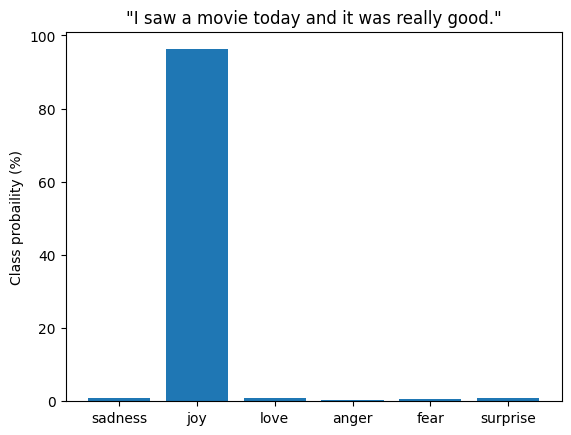

In [147]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"], color="C0")
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probaility (%)")
plt.show()